# Pattern Recognition Course
## Lab 2: Face Recognition

---

## Import Libraries

In [10]:
import kagglehub
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from math import log2


## Prepare Dataset

- ### Read Images

In [14]:
# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
images = []
labels = []

# Loop through each subject folder (s1 to s40)
for subject in sorted(os.listdir(path)):
    subject_path = os.path.join(path, subject)
    
    # Skip if not a directory
    if not os.path.isdir(subject_path):
        continue

    # Get the subject number from folder name (s1 -> 0, s2 -> 1, etc.)
    subject_num = int(subject[1:]) - 1
    
    # Loop through each image in the subject folder
    for image_file in sorted(os.listdir(subject_path)):
        if image_file.endswith('.pgm'):  # AT&T uses PGM format
            image_path = os.path.join(subject_path, image_file)
            
            # Open and convert to numpy array
            img = Image.open(image_path)
            img_array = np.array(img)
            
            images.append(img_array)
            labels.append(subject_num)

images, labels = np.array(images), np.array(labels)

print(f"Dataset loaded with {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Number of classes: {len(np.unique(labels))}")

Dataset loaded with 400 images
Image shape: (112, 92)
Number of classes: 40


- ### Generate the Data Matrix

In [17]:
# Calculating number of pixels (features) for each image
row_pixels, col_pixels = images[0].shape
pixels_number = row_pixels * col_pixels

# Initialize data matrix and target vector
X = np.ndarray((len(images), pixels_number))
y = np.array(labels)

# Fill the data matrix
for i, img in enumerate(images):
    X[i] = img.flatten()

print(f'Data Matrix Shape{X.shape}')
print(f'Target Vector Length {y.shape}')

Data Matrix Shape(400, 10304)
Target Vector Length (400,)


- ### Generate Training and Test Sets

In [20]:
# Even rows for testing, Odds for training
X_train, X_test = X[1::2], X[::2]
y_train, y_test = y[1::2], y[::2]
print(f'Training Set Matrix Shape {X_train.shape}, Training Labels Length {y_train.shape}')
print(f'Test Set Matrix Shape {X_test.shape}, Test Labels Length {y_test.shape}')

Training Set Matrix Shape (200, 10304), Training Labels Length (200,)
Test Set Matrix Shape (200, 10304), Test Labels Length (200,)


## Principal Component Analysis 

- ### Implementation

In [29]:
# Facilitating an interface for the technique
class PCA:

    # Constructor, needs retained variance percentage and training data
    def __init__(self, alpha):
        # Percentage of total variance to be retained in the model
        self.alpha = alpha
        # Eigenvalues of the covariance matrix (d_features)
        self.eigenvalues = np.array([])
        # Eigenvectors of the covariance matrix (d_features, d_features)
        self.eigenvectors = np.array([[]])
        # Total Variance in the training set
        self.total_variance = 0.0
        # Highest-varianced principal components that retain alpha% of total variance (d_features, k_components)
        self.principal_components = np.array([[]])
        """
        # Projected training set on the new components [Proj(X)] (n_samples, k_components)
        self.X_projected = np.array([[]])
        # Reconstructed training set (n_samples, d_features)
        self.X_reconstructed = np.array([[]])
        """

    def generate_principal_components(self, X):
        """
        Generates the whole set of principal components with their corresponsing eigenvalues.
        Accumulates the total variance of the training set.
        """
        try:
            eigens = np.load('eigen.npz')
            self.eigenvalues, self.eigenvectors = eigens['eigenvalues'], eigens['eigenvectors']
            print("Eigenvalues and eigenvectors are already saved.")
        except FileNotFoundError:
            print("Calculating eigenvectors and eigenvalues for the first time and saving both.")
            cov = np.cov(X, rowvar=False)
            self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov)
            
            # Reverse for descending order
            self.eigenvalues = self.eigenvalues[::-1]
            self.eigenvectors = self.eigenvectors[:, ::-1]
            np.savez('eigen.npz', eigenvalues=self.eigenvalues, eigenvectors=self.eigenvectors)
            
        self.total_variance = sum(self.eigenvalues)
        print(f"Number of eigenvalues: {self.eigenvalues.shape}")
        print(f"Principal components shape: {self.eigenvectors.shape}")
    
    def construct_reduced_subspace(self):
        """
        Construct the new PCA subspace with heighest-varianced components 
        that retain the required percentage of total variance.
        """
        variance_to_retain = self.alpha * self.total_variance
        retained_variance = 0.0
        k = 0  # Number of components to keep, eigenvetors are sorted based on each's variance
    
        while retained_variance < variance_to_retain:
            retained_variance += self.eigenvalues[k]
            k += 1
    
        self.principal_components = self.eigenvectors[:, :k]
    
    def fit_transform(self, X):
        """
        Returns X_projected: New representation of the data matrix X (n_samples, k_components)
        where k is the number of the heighest-varianced components that retains the required percentage of total variance
        """
        self.generate_principal_components(X)
        self.construct_reduced_subspace()
        return np.matmul(X, self.principal_components)

    def inverse_transform(self, X_projected):
        """
        Returns the reconstructed data representation of X_projected
        """
        print(X_projected.shape)
        print(self.principal_components.T.shape)
        return np.matmul(X_projected, self.principal_components.T)

    def project(self, X):
        """
        Returns projection of X into the new subspace
        """
        return np.matmul(X, self.principal_components)
        

- ### Testing with Different Alpha 

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
(200, 36)
(36, 10304)


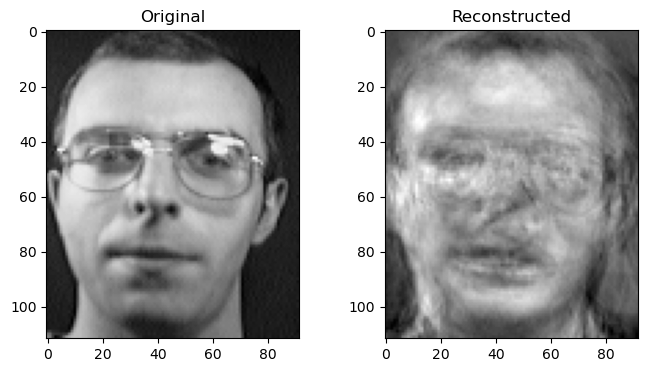

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
(200, 52)
(52, 10304)


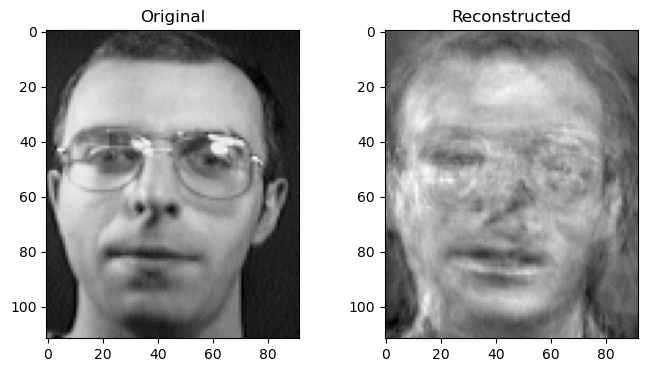

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
(200, 76)
(76, 10304)


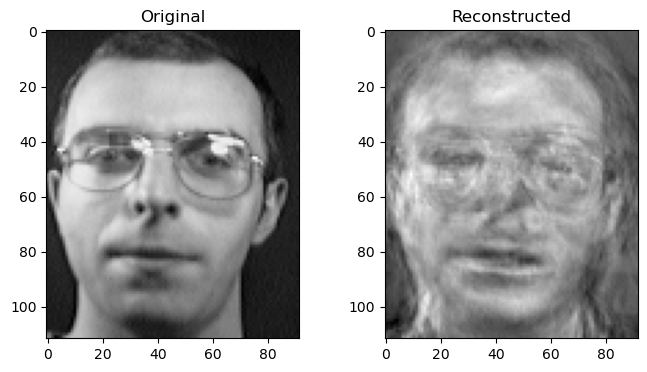

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
(200, 117)
(117, 10304)


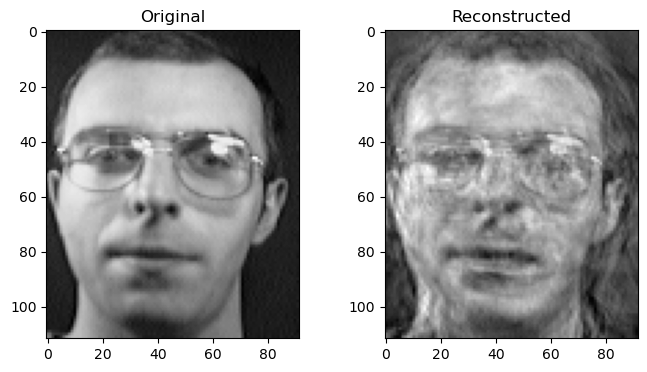

In [38]:
def plot_reconstruction(original, reconstructed):
    """
    Plotting original vs reconstructed images
    """
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(112, 92), cmap='gray')
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(112, 92), cmap='gray')
    plt.title("Reconstructed")
    plt.show()

alphas = [0.8, 0.85, 0.9, 0.95]
for alpha in alphas:
    model = PCA(alpha)
    X_projected = model.fit_transform(X_train)
    X_reconstructed_pca = model.inverse_transform(X_projected)
    plot_reconstruction(X_train[50], X_reconstructed_pca[50])